In [1]:
from mltoolbox.basic import *

In [2]:
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms

from pathlib import Path
import math, os

In [4]:
from mltoolbox.image import stats_dict

In [5]:
sz=512

In [ ]:
PATH = Pathth
df = 

In [6]:
train_meta = pd.read_csv('data/metadata_train.csv')
train_meta.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [7]:
train, valid = split_df(train_meta)

In [8]:
train.target.value_counts()

0    6580
1     410
Name: target, dtype: int64

In [9]:
valid.target.value_counts()

0    1607
1     115
Name: target, dtype: int64

In [8]:
train = balance_dataset(train, target_col='target')

Let's balance only the training set, and not the validation set.

In [11]:
train.target.value_counts()

1    6580
0    6580
Name: target, dtype: int64

In [9]:
from mltoolbox.image import *

In [10]:
SAMPLE_LENGTH = 800000
SAMPLE_TIME = 20e-3
SAMPLING_RATE = SAMPLE_LENGTH / SAMPLE_TIME

In [11]:
class VSBDataset(Dataset):
    def __init__(self, df):
        self.num_files = df.shape[0]
        self.signal_id = df.signal_id.values
        self.labels = df.target.values

    def __len__(self):
        return self.num_files

    def __getitem__(self, idx):
        sig_idx = self.signal_id[idx]
        y = self.labels[idx]
        x = imread_fast(f'data/gadf_grams/{sig_idx}.jpg')
        x = im_int2float(x)
        x = normalize_image(x)
        x =  np.rollaxis(x, 2)
        return x, y

In [12]:
train_ds = VSBDataset(train)
valid_ds = VSBDataset(valid)

In [16]:
x, y = train_ds[900]
x.shape

(3, 512, 512)

In [17]:
y

1

In [16]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [41]:
resnet = models.resnet34(pretrained=True)

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = F.relu(self.top_model(x.float().cuda()))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        # x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        # x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [43]:
model = Net().cuda()

In [22]:
x, y = next(iter(valid_dl))

In [23]:
x.shape

torch.Size([64, 3, 512, 512])

In [24]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0])

In [25]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 1])

In [26]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0])

In [27]:
y_hat.squeeze().detach().cpu() > 0

tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=torch.uint8)

In [16]:
from mltoolbox.dl import get_optimizer, save_model, load_model, lr_range_finder

In [17]:
from mltoolbox.dl import plot_lr

In [18]:
loss_criteria = F.binary_cross_entropy_with_logits

In [19]:
plt.rcParams['figure.figsize'] = [15.0, 6.0]

In [32]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

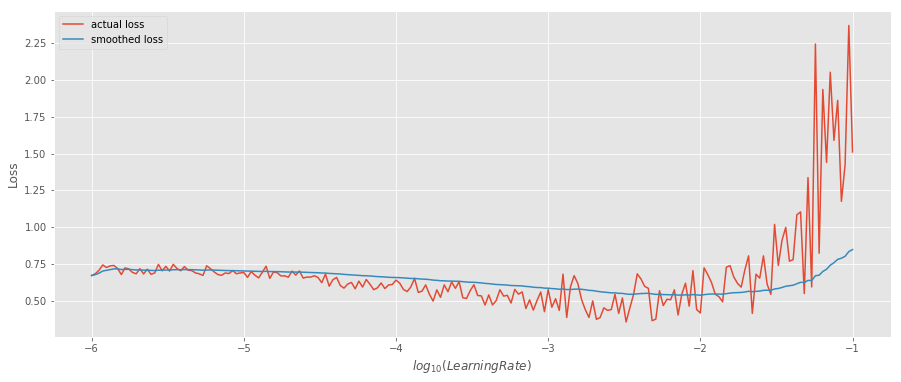

In [33]:
plot_lr(log_lrs, losses, smooth_losses)

In [32]:
best_lr = 10**(-2.5)
best_lr

0.0031622776601683794

In [20]:
from mltoolbox.dl import get_triangular_lr, val_metrics, train_triangular_policy,\
    training_loop

In [21]:
from sklearn.metrics import matthews_corrcoef, accuracy_score

Checking if all the images are able to be loaded

In [38]:
for i in progress_bar(range(0, 8712)):
    try:
        im = imread_fast(f'data/gadf_grams/{i}.jpg')
    except:
        print(i)

In [39]:
val_metrics(model=model, valid_dl=valid_dl,
            metrics=[accuracy_score, matthews_corrcoef], loss_criteria=loss_criteria)

{'val_loss': 0.697062303864859,
 'accuracy_score': 0.4645760743321719,
 'matthews_corrcoef': 0.05191299888124986}

Classical case of over fitting !!

In [44]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=0.0031, epochs=3)

Epoch No.:1, Train loss: 0.4379, val_loss: 0.3779, accuracy_score: 0.8362, matthews_corrcoef: 0.1918, 
Epoch No.:2, Train loss: 0.1810, val_loss: 0.3955, accuracy_score: 0.8943, matthews_corrcoef: 0.1382, 
Epoch No.:3, Train loss: 0.0382, val_loss: 0.4249, accuracy_score: 0.9117, matthews_corrcoef: 0.1179, 
train_triangular_policy 1460.48 s


Let's do only on epoch now.

In [48]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=0.0031, epochs=1)

Epoch No.:1, Train loss: 0.3839, val_loss: 0.3343, accuracy_score: 0.8496, matthews_corrcoef: 0.1732, 
train_triangular_policy 493.30 s


In [49]:
save_model(model, 'models/frozen.mdl')

In [37]:
load_model(model, 'models/frozen.mdl')

In [23]:
from mltoolbox.dl import set_trainable_attr, unfreeze

In [38]:
for i in range(3, 8):
    unfreeze(model, i)

In [39]:
model.cuda()

batch_size = 24

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [26]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

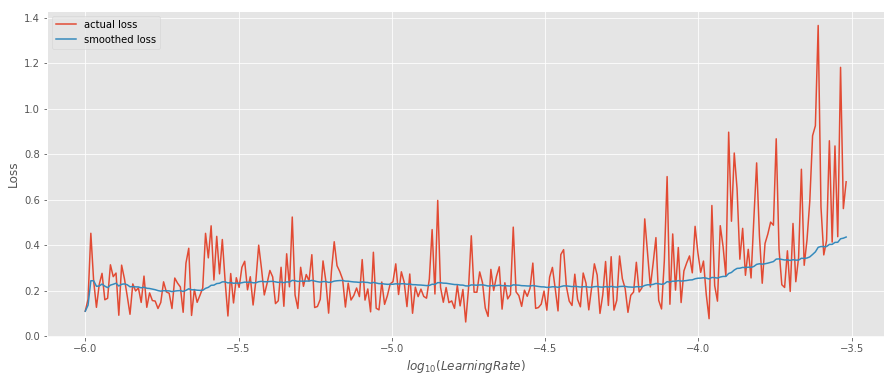

In [32]:
plot_lr(log_lrs, losses, smooth_losses)

In [45]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-4.5), epochs=1)

Epoch No.:1, Train loss: 0.5389, val_loss: 0.5190, accuracy_score: 0.6847, matthews_corrcoef: 0.1957, 
train_triangular_policy 373.10 s
